# Sensitivity Analysis for RL Control Policies

### Imports

In [1]:
# imports
import os
import torch

# local imports
from utils import (
    rollout2trajectory,
    compute_state_statistics,
    compute_jacobian,
    compute_hessian,
    compute_sensitivity,
    compute_batch_multistep_sensitivity,
    compute_perturbation_error,
    compute_batch_perturbation_error,
    compute_projection_distances,
    compute_linearization,
    plot_matrix,
    plot_1d,
    plot_2d,
    plot_multistep_sensitivity,
    plot_perturbation_error,
    plot_projection_distances,
)

In [2]:
# load policy
export_dir = "../artifacts/point_mass/2025-11-27_12-15-37"
policy_path = os.path.join(export_dir, "policy_jit.pt")
rollout_path = os.path.join(export_dir, "rollout.pt")
io_path = os.path.join(export_dir, "policy_io.txt")
policy = torch.jit.load(policy_path).eval()
rollout = torch.load(rollout_path)
with open(io_path, "r") as f:
    print(f.read())
rollout_obs, rollout_actions, rollout_dones = rollout2trajectory(rollout)
print(f"Rollout Data: {rollout_obs.numpy().shape}")

<ActionManager> contains 1 active terms.
+----------------------------------+
|  Active Action Terms (shape: 2)  |
+-------+--------------+-----------+
| Index | Name         | Dimension |
+-------+--------------+-----------+
|   0   | joint_effort |         2 |
+-------+--------------+-----------+

<ObservationManager> contains 1 groups.
+---------------------------------------------------+
| Active Observation Terms in Group: 'policy' (shape: (4,)) |
+--------------+---------------------+--------------+
|    Index     | Name                |    Shape     |
+--------------+---------------------+--------------+
|      0       | pose                |     (2,)     |
|      1       | velocity            |     (2,)     |
+--------------+---------------------+--------------+

Rollout Data: (100, 8192, 4)


### Sensitivity Matrix

#### Jacobian

Let $J(x)=\nabla_x \bar u(x) \in \mathbb{R}^{|x|\times|u|}$ be the gradient of the mean control action with respect to the observation with $\bar u(x) = \mathbb{E}\left [\pi(u|x) \right ]$. This Jacobian represents how much the control action changes given a change in the observed state.

#### Local Sensitivity
$$C(x) = J(x)^T J(x)\in \mathbb{R}^{|x|\times|x|}$$

#### Global Approximation of Sensitivity
$$\hat C = \mathbb{E}_{x\sim p_\tau}\left [ J(x)^T J(x) \right ]$$

Let $x_0 \sim \rho(x_0)$ be a uniform prior. Then the marginal visitation distribution induced by $\rho(x_0)$ is given by 

$$p(x_t) = \rho(x_0)\prod^{t-1}_{k=0}T(x_{k+1}|x_k,u_k)\pi(u_k|x_k)$$

with stochastic state transition density $T$ and controller $\pi$. We define the liklihood over the trajectory as 

$$p_\tau(x_0,...,x_t) := \int_{k=0}^{t} p(x_k)dx_k.$$

In practice, we do not have an analytic form for the state transition density and so perform Monte Carlo sampling. Given $N$ rollouts over horizon length $T$ we collect trajectories $\tau=\{(x_0,u_0),(x_1,u_1),...,(x_T,u_T) \}$ with control actions sampled as $u_k\sim\pi(u_k|x_k)$. We then form an approximate state distribution such that $|X_\text{rollout}| = T * N$.

Expanding the expected value yields

$$\hat C = \int_{X_\text{rollout}} p_\tau(x) J(x)^T J(x) dx \approx \frac{1}{|X_\text{rollout}|}\sum_{X_\text{rollout}} J(x)^T J(x)$$

approximated via Monte Carlo. Practically, to prevent overflow for very large samples sizes, the sensitivity can be found iteratively via partial sums for $k=\{0,1,...,|X_\text{rollout}|\}$

$$C(x_k) = J(x_k)^TJ(x_k) \qquad \hat C_0 = C(x_0)$$
$$\hat C_{k+1} = \hat C_k + \frac{1}{k+1}(C(x_{k+1}) - \hat C_k)$$

#### Spectral Analysis

The eigenvalues and eigenvectors of the sensitivity matrix are given by

$$Cv=\lambda v.$$

The direction of worst-case sensitivity is given by the eigenvector $v$ corresponding to the largest eigenvalue $\lambda_\text{max}$.



analysis:
- does history length get used? for double integrator, dont use velocity, only position. rewards for poseition, vel, accel and every sub combo with different history lengths
- is full state space needed for go1?
- plot sensitivity over a trajectory
- quantify symmetry
- quantify sim2real? function of sensitivity (train with and without DR for a given obs and see difference in sensitivity)
- design vs. deployment issues (eg cant change observation space at runtime)
- global eigvec (worst case direction) vs local
- project current state onto global eigvecs / local eigvecs to measure how close to sensitive region
- gradient penalty to enforce symmetric sensitivity? (eg left/right for the same joint)

In [3]:
# r = torch.empty(10, 4, dtype=torch.float32)
# states = r.uniform_(-1.0, 1.0)
# compute_state_statistics(states)
# C, eigvals, eigvecs, explained_energy, input_activity = compute_sensitivity(policy, states)

# plot_matrix(C, "Sensitivity Matrix (Uniform Prior)")
# plot_semilogy(eigvals, "Eigenvalue Spectrum (Uniform Prior)", "Eigenvalue Index", "log(Eigenvalue)")

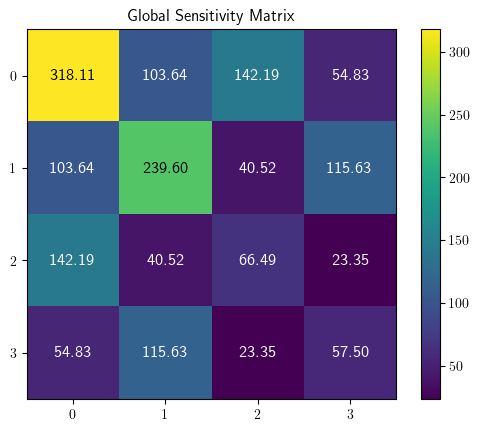

In [4]:
# sensitivity matrix
states = rollout_obs
states_flat = states.reshape(-1, 4)
# compute_state_statistics(states_flat)
C_global, eigvals_global, eigvecs_global, explained_energy_global, input_activity_global = compute_sensitivity(policy, states_flat)
plot_matrix(C_global, "Global Sensitivity Matrix")

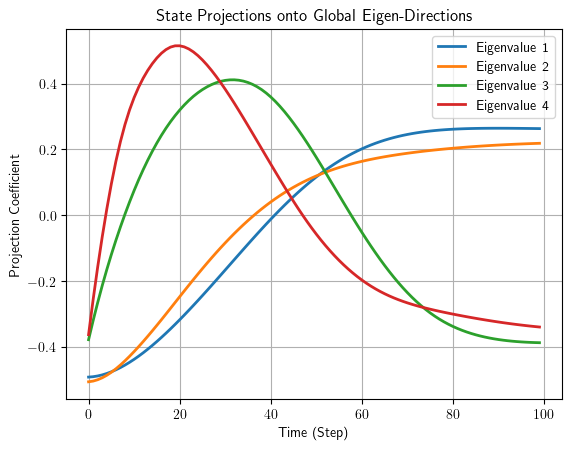

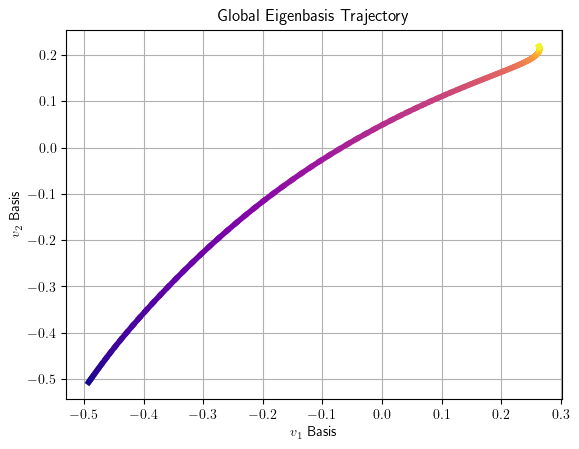

In [11]:
proj_dist_global_dir = compute_projection_distances(states[:, 0], eigvecs_global, mean_center=True)
plot_1d(proj_dist_global_dir, f"State Projections onto Global Eigen-Directions", "Time (Step)", "Projection Coefficient", prefix="Eigenvalue ")
plot_2d(proj_dist_global_dir, "Global Eigenbasis Trajectory", r"$v_1$ Basis", r"$v_2$ Basis", temporal=True, linewidth=4)
# proj_dist_all = compute_projection_distances(states_flat, eigvecs_global, mean_center=True)
# plot_2d(proj_dist_all, "Global Eigenbasis Trajectory", r"$v_1$ Basis", r"$v_2$ Basis", temporal=True, linewidth=4)

### Spectral Analysis
$$Cv=\lambda v$$

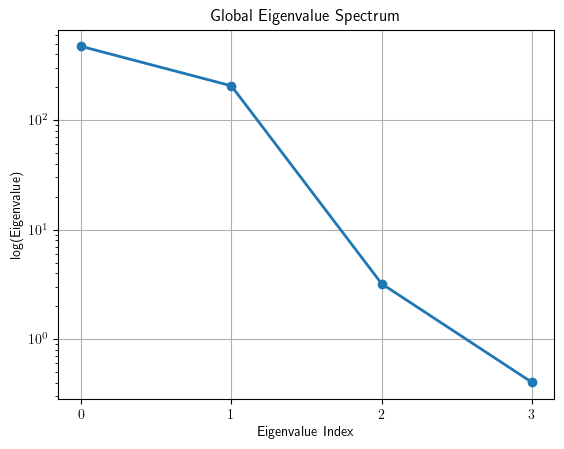

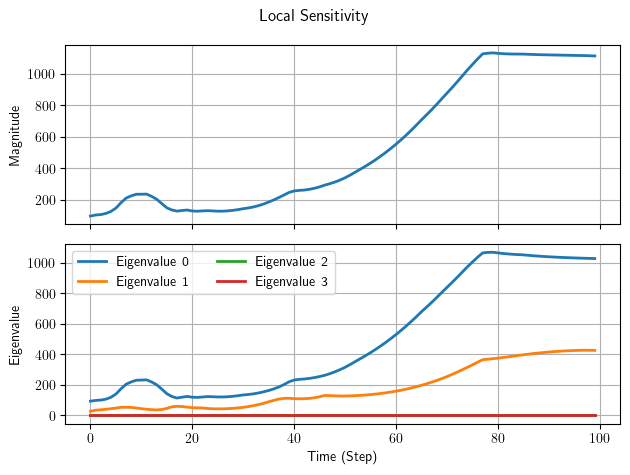

In [6]:
plot_1d(eigvals_global, "Global Eigenvalue Spectrum", "Eigenvalue Index", "log(Eigenvalue)", logy=True, xticks=True, marker="o")
out = compute_batch_multistep_sensitivity(policy, rollout_obs[:, [0]])
C_traj, eigvals_traj, eigvecs_traj, explained_energy_traj, input_activity_traj = out
plot_multistep_sensitivity(C_traj, eigvals_traj, log=False)

### Explained Energy
$$E_i=\frac{\sum_j^i\lambda_j}{\sum\lambda}$$

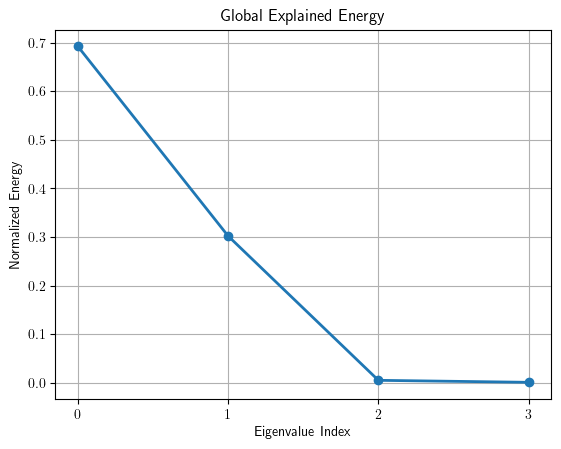

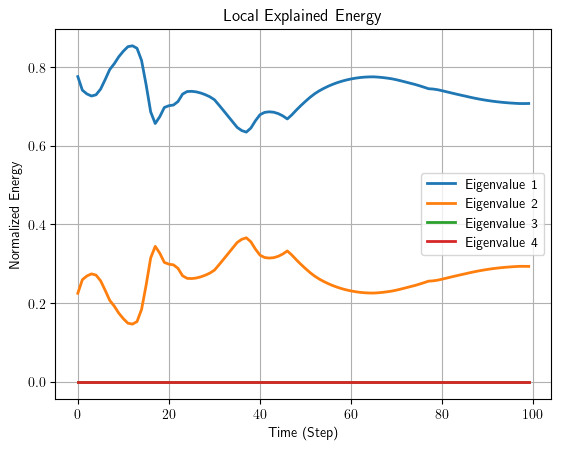

In [7]:
plot_1d(explained_energy_global, "Global Explained Energy", "Eigenvalue Index", "Normalized Energy", marker="o", xticks=True)
plot_1d(explained_energy_traj.squeeze(dim=1), "Local Explained Energy", "Time (Step)", "Normalized Energy", prefix="Eigenvalue ")

### Active Subspace
$$\alpha_i=\sum_j\lambda_jv_{ji}^2$$

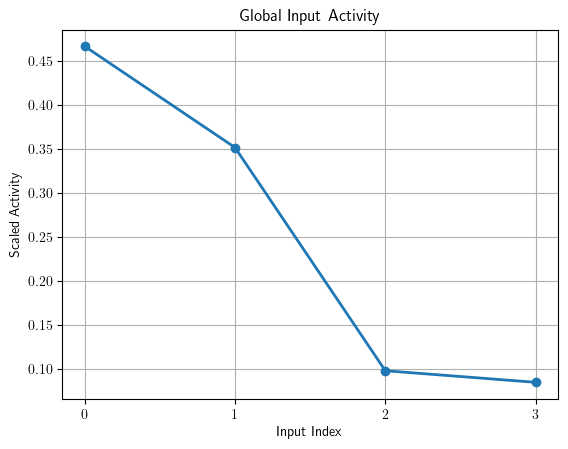

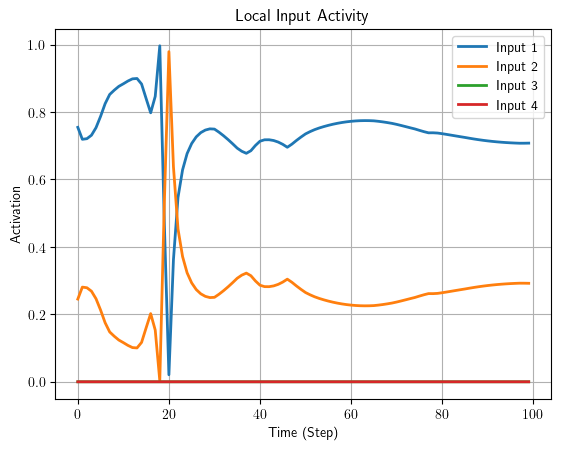

In [8]:
plot_1d(input_activity_global, "Global Input Activity", "Input Index", "Scaled Activity", marker="o", xticks=True)
plot_1d(input_activity_traj.squeeze(dim=1), "Local Input Activity", "Time (Step)", "Activation", prefix="Input ")

### Sensitivity to Perturbation
$$\max_{v}||\pi(x+\alpha v) - \pi(x)|| \approx \alpha||J(x) v||$$

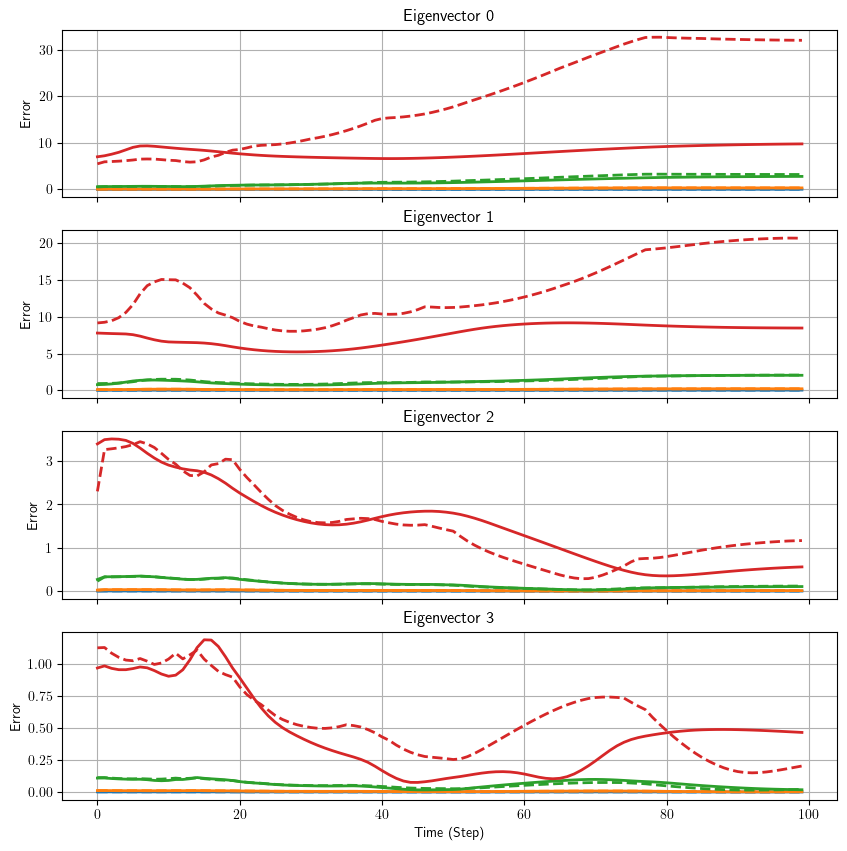

In [9]:
radii = [0.001, 0.01, 0.1, 1.0]
errors, errors_linear = compute_perturbation_error(policy, rollout_obs, eigvecs_global, radii, env_idx=0)
plot_perturbation_error(errors, errors_linear, eigvecs_global, radii, log=False)

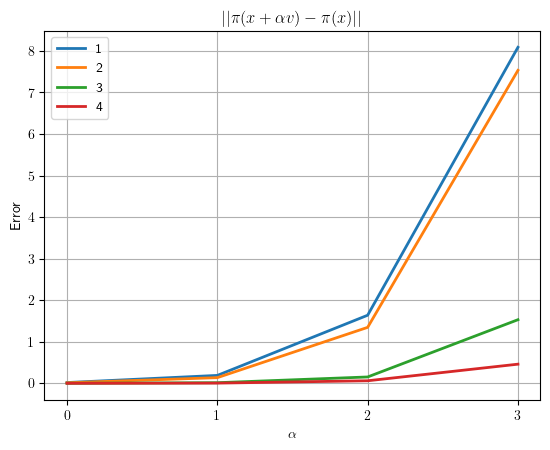

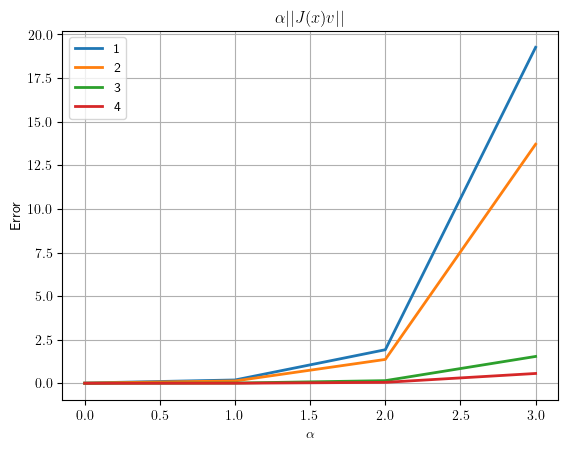

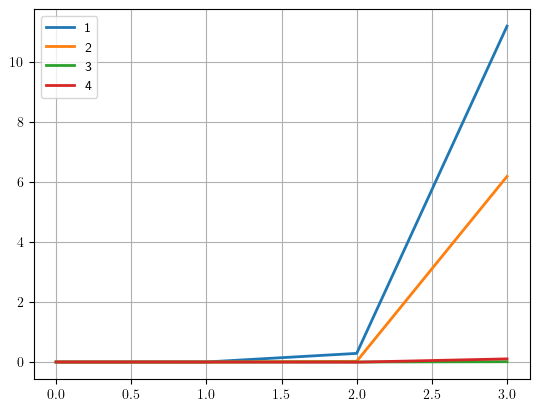

In [10]:
errors, errors_linear = compute_batch_perturbation_error(policy, rollout_obs, eigvecs_global, radii)
plot_1d(errors.T, r"$||\pi(x+\alpha v) - \pi(x)||$", r"$\alpha$", "Error", xticks=True, logx=False)
plot_1d(errors_linear.T, r"$\alpha||J(x)v||$", r"$\alpha$", "Error")
plot_1d(errors_linear.T - errors.T, "", "", "")